# Linear Regression - Example

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [4]:
data_for_model = pickle.load(open("data/abc_abc_regression_modelling.p", "rb"))

In [5]:
data_for_model.drop("customer_id", axis = 1, inplace = True)

In [6]:
# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

In [7]:
# deal with missing values
data_for_model.isna().sum()

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [9]:
data_for_model.dropna(how = "any", inplace = True)

In [11]:
# deal with Outliers
outlier_investigation = data_for_model.describe()
outlier_investigation

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [14]:
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

for column in outlier_columns:
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace = True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


In [16]:
# split input variables & output variable
X = data_for_model.drop(["customer_loyalty_score"], axis = 1)
y = data_for_model["customer_loyalty_score"]

In [17]:
# split out training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
# deal with categorical variables
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop = 'first')

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True), X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True), X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)


C:\Users\sophi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
X_train

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.19,0.57,1096.96,202,53,5,20.697358,1.0
1,0.39,0.43,933.39,220,51,4,18.301765,1.0
2,2.27,0.49,1506.49,281,47,3,32.052979,0.0
3,3.10,0.59,330.79,81,13,4,25.445385,0.0
4,0.07,0.53,2053.04,210,54,5,38.019259,1.0
...,...,...,...,...,...,...,...,...
290,1.02,0.64,2490.66,263,51,5,48.836471,1.0
291,0.66,0.45,3183.80,285,52,5,61.226923,1.0
292,2.60,0.48,1815.22,306,43,4,42.214419,0.0
293,1.81,0.54,1208.05,272,46,4,26.261957,0.0


In [20]:
X_test

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.80,0.41,1524.01,278,45,3,33.866889,0.0
1,1.92,0.64,1992.51,305,53,5,37.594528,0.0
2,4.38,0.47,343.41,70,12,4,28.617500,0.0
3,1.51,0.59,1208.91,198,55,5,21.980182,0.0
4,2.52,0.50,1967.39,316,55,5,35.770727,0.0
...,...,...,...,...,...,...,...,...
69,1.31,0.75,1773.33,325,45,4,39.407333,1.0
70,0.45,0.56,1342.64,221,55,5,24.411636,1.0
71,1.59,0.50,1740.37,303,52,5,33.468654,1.0
72,4.76,0.52,2996.02,357,49,5,61.143265,0.0


In [21]:
# feature selection
regressor = LinearRegression()
feature_selector = RFECV(regressor)
fit = feature_selector.fit(X_train,y_train)

In [22]:
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

Optimal number of features: 8


In [23]:
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

C:\Users\sophi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Feature Selection using RFE \n Optimal number of features is 8')

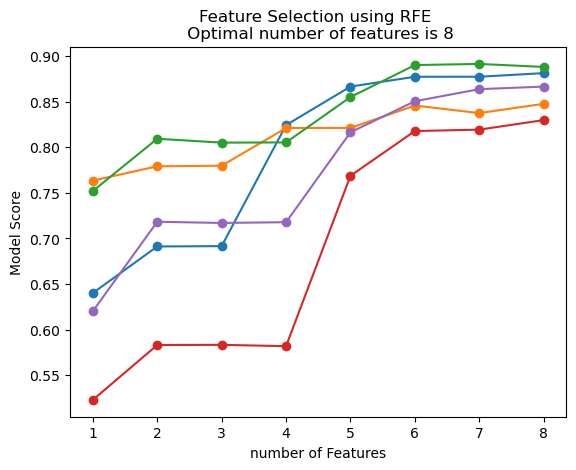

In [24]:
plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count}")

In [26]:
# model training
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [27]:
# predict on the test set
y_pred = regressor.predict(X_test)

In [28]:
# calculate r-squared
r_squared = r2_score(y_test, y_pred)
r_squared

0.7805702910327408

In [29]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = "r2")
cv_scores.mean()

0.8532327536589764

In [33]:
# calculate adjusted r-squared
num_data_point, num_input_vars = X_test.shape
print(num_data_point, num_input_vars)
adjusted_r_squared = 1 -(1-r_squared)*(num_data_point-1)/(num_data_point - num_input_vars -1)
print(adjusted_r_squared)

74 8
0.7535635576213858


In [34]:
# extract model coefficients
coefficients = pd.DataFrame(regressor.coef_)
coefficients

,0
0,-0.201232
1,-0.027697
2,0.000142
3,0.001002
4,-0.004842
5,0.061659
6,-0.003971
7,-0.013393


In [35]:
input_variable_names = pd.DataFrame(X_train.columns)
summary_stats = pd.concat([input_variable_names,coefficients], axis = 1)
summary_stats.colums = ["input_variable", "coefficient"]
summary_stats

C:\Users\sophi\AppData\Local\Temp\ipykernel_174948\4107146612.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  summary_stats.colums = ["input_variable", "coefficient"]


,0,0
0,distance_from_store,-0.201232
1,credit_score,-0.027697
2,total_sales,0.000142
3,total_items,0.001002
4,transaction_count,-0.004842
5,product_area_count,0.061659
6,average_basket_value,-0.003971
7,gender_M,-0.013393


In [36]:
# extract model intercept
regressor.intercept_

0.5160974174646067